# **CAL FIRE Trend Forecasting and Analysis**


## Description and deliverables

California experiences some of the most severe and frequent wildfires in the United States. With the current tides of climate change, population growth, and developing land uses, understanding patterns of wildfire activity is becoming an increasingly important consideration for the residents and government of California. To better understand these patterns and support proactive decision-making, this project focuses on trend forecasting and analysis using historical incident data provided by CAL Fire.

The project integrates data analytics and machine learning techniques to explore wildfire behavior, identify risk factors, and generate predictive insights. The workflow begins with acquiring raw incident data directly from CAL FIRE's public databases, followed by data cleaning, transformation, and storage in a relation database for efficient querying. Exploratory data analysis (EDA) highlights temporal, geographic, and environmental patterns to allow for further insights. Additionally, machine learning techniques are applied to the data in order to uncover even more trends that display wildfire activity analytics.

The end product is a data pipeline and interactive dashboard that automatically updates with new incident data, delivering actionable insights to fire management agencies, policymakers, and researchers. This allows stakeholders to track wildfire activity in realtime, monitor trends, and simulate future scenarios to improve preparedness, resource allocation, and public safety.

This notebook serves as the back-bone of this project's workflow. While all dashboards, visualizations, and metrics can be viewed by running the core Python file, this notebook keeps track of the ins-and-outs of the decision-making behind the analysis.

## Exploratory Data Analysis (EDA)

In the dataset provided by [CAL FIRE](https://www.fire.ca.gov/), detailed records of wildfire incidents across California are made publicly available. The data can be accessed directly through CAL FIRE's open data portal [here](https://incidents.fire.ca.gov/imapdata/mapdataall.csv), which is updated regularly to reflect both active and historical incidents.

This dataset includes a number of attributes, but the ones we will be focusing on are:
Variable|Description |
-----|-----|
incident_name | The official name or title of the wildfire incident.|
incident_date_created | The date and time when the incident was first reported or created in the system.|
incident_administrative_unit | The CAL FIRE administrative unit or agency responsible for managing the incident.|
incident_county | The county in California where the incident occurred.|
incident_location | A descriptive location of the incident, such as city, town, or nearby landmark.|
incident_acres_burned | The total number of acres burned during the incident.|
incident_containment | The percentage of the fire that has been contained at the time of reporting.|
incident_cooperating_agencies | Other local, state, or federal agencies assisting with the incident response.|
incident_longitude | The longitude coordinate of the incident’s location.|
incident_latitude | The latitude coordinate of the incident’s location.|
incident_id | A unique identifier assigned to each incident (string or numeric).|
incident_url | A direct link to the CAL FIRE incident webpage for more details.|
incident_date_extinguished | The date and time when the incident was declared fully extinguished.|
is_active | Status flag indicating whether the incident is still active or has been contained/closed. |
calfire_incident | Boolean value indicating whether the incident was directly managed by CAL FIRE. |

In the dataset provided by the Government of California's API, detailed records of monthly precipitation levels for each County across California are made publicly available. The link to the API can be found [here](https://lab.data.ca.gov/dataset/annual-precipitation-data-for-northern-california-1944-current/c66bcc83-d895-48cf-a639-a53974899b88).

This dataset includes a number of attributes, but the ones we will be focusing on are:
Variable|Description |
-----|-----|
incident_name | The official name or title of the wildfire incident.|
precip_date | The datetime in which the record comes from. |
precip_inches | The total inches of precipitation in each county, in each month. |
precip_month | Number equating to the month of the year. |
county | The county from which the record is referring to.

## Step 1. Initializing a Database for CAL FIRE Data

The first step in our analysis is to construct a database to store the most up-to-date 'incidents' data. For this task, we will be initializing a Google Cloud PostgreSQL instance and creating/uploading/verifying our database automatically when the username and password are entered. The included Python script in this repository, "download_data.py", will complete this when run in the next code block if execute is set to "True" (Only enable if database is online). After, all we have to do is query the data and begin EDA!

In [45]:
# Execute the creation of Database
create = True
# Set to true if PostgreSQL database is online
accessible = True
instance_connection_name = 'potent-hue-467421-m2:us-west1:wildfires-postgres'
db_user = 'postgres'
db_pass = '44Puapoe!'

In [46]:
import download_wildfire
if create:
    try:
        download_wildfire.main(instance_connection_name, db_user, db_pass)
        print("Database created successfully")
    except Exception as e:
        print(f"Database creation failed: {e}")
if accessible:
    df = download_wildfire.load_data(instance_connection_name, db_user, db_pass)

DEBUG - Using selector: SelectSelector
DEBUG - Starting new HTTPS connection (1): oauth2.googleapis.com:443
DEBUG - https://oauth2.googleapis.com:443 "POST /token HTTP/1.1" 200 None


Database calfire_db already exists.
Database connection successful
Table 'incidents' ensured.


DEBUG - Using selector: SelectSelector


Downloaded 3259 records from CAL FIRE


DEBUG - Starting new HTTPS connection (1): oauth2.googleapis.com:443
DEBUG - https://oauth2.googleapis.com:443 "POST /token HTTP/1.1" 200 None


Database engine created successfully


DEBUG - Using selector: SelectSelector


Data upload complete. Up to date as of 2025-08-28 23:47:45
Database created successfully


DEBUG - Starting new HTTPS connection (1): oauth2.googleapis.com:443
DEBUG - https://oauth2.googleapis.com:443 "POST /token HTTP/1.1" 200 None


Database engine created successfully


## Step 2. Data Exploration

Now that we have saved the data in a dataframe, "df", it is important to develop a fundamental understanding of our data. While the basic data cleaning occurs during the initialization of the database, we can look deeper into the data to discover further trends.

### Gather basic information about the data

In [26]:
import pandas as pd
import os
#df = df[df['incident_date_created'] > "2016-01-01"]
df = df[df['incident_date_created'].dt.year >= 2015]
df['incident_county'] = df['incident_county'].str.split(",").str[0].str.strip()
df = df[~df['incident_county'].isin(['State of Nevada','State of Oregon','Mexico'])]
df_original = df.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3029 entries, 0 to 3033
Data columns (total 17 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   id                             3029 non-null   int64         
 1   incident_name                  3029 non-null   object        
 2   incident_date_created          3029 non-null   datetime64[ns]
 3   incident_administrative_unit   2966 non-null   object        
 4   incident_county                3021 non-null   object        
 5   incident_location              3029 non-null   object        
 6   incident_acres_burned          2976 non-null   float64       
 7   incident_containment           2971 non-null   float64       
 8   incident_cooperating_agencies  1468 non-null   object        
 9   incident_longitude             3029 non-null   float64       
 10  incident_latitude              3029 non-null   float64       
 11  incident_id           

In [27]:
df.describe()

,id,incident_date_created,incident_acres_burned,incident_containment,incident_longitude,incident_latitude,incident_date_extinguished,data_loaded_date
count,3029.000000,3029,2.976000e+03,2971.000000,3.029000e+03,3029.000000,2285,3029
mean,1737.634533,2021-04-21 13:30:31.868273408,3.839194e+03,99.734096,-3.934557e+05,38.778123,2020-08-30 02:33:50.550109440,2025-08-28 00:35:13.602187776
min,1.000000,2015-02-24 12:15:00,0.000000e+00,0.000000,-1.191415e+09,-120.258000,2015-03-02 09:00:00,2025-08-28 00:35:13.602188
25%,977.000000,2018-06-13 21:06:00,2.500000e+01,100.000000,-1.216216e+02,34.701000,2018-01-09 13:19:00,2025-08-28 00:35:13.602188032
50%,1740.000000,2021-03-27 17:02:04,6.700000e+01,100.000000,-1.204374e+02,37.066483,2019-10-07 18:34:00,2025-08-28 00:35:13.602188032
75%,2497.000000,2024-07-13 15:27:39,2.780000e+02,100.000000,-1.185336e+02,39.023000,2023-08-16 06:19:00,2025-08-28 00:35:13.602188032
max,3254.000000,2025-08-27 14:12:32,1.032648e+06,100.000000,1.189082e+02,5487.000000,2025-08-27 08:00:00,2025-08-28 00:35:13.602188
std,877.222394,NaN,3.374544e+04,4.318231,2.164777e+07,99.161651,NaN,NaN


In [28]:
df.isna().sum()

id                                  0
incident_name                       0
incident_date_created               0
incident_administrative_unit       63
incident_county                     8
incident_location                   0
incident_acres_burned              53
incident_containment               58
incident_cooperating_agencies    1561
incident_longitude                  0
incident_latitude                   0
incident_id                         0
incident_url                        0
incident_date_extinguished        744
is_active                           0
calfire_incident                    0
data_loaded_date                    0
dtype: int64

### Missing Values

The above function tells us more about what data is and is not available. It seems as though there are some NaN values for some attributes. Some of these null values will have no impact on the analysis, but some will. We can take care of those. It is important to remember, as new data is released, more entries will added which may contain NaN values. We will handle these differently for each variable.

* 'incident_acres_burned' has a few NaN value at the time of analysis, which is hard to impute so we can drop that row and any future entries with NaN.
* 'incident_county' is also NA, but in minimum quantities, so we will drop this as well.
* 'incident_administrative_unit' has 63, but the attribute itself is not very impactful on our research.
* 'incident_cooperating_agencies' is similar to admin unit, it is not super important.
* 'incident_containment' can be solved by checking if the fire is active or not.
* 'incident_date_extinguished' is tricky, we will have to solve this NaN value issue to complete our analysis.

In [29]:
df = df.dropna(subset = ['incident_acres_burned', 'incident_county', 'incident_containment'])
df.isna().sum()

id                                  0
incident_name                       0
incident_date_created               0
incident_administrative_unit       58
incident_county                     0
incident_location                   0
incident_acres_burned               0
incident_containment                0
incident_cooperating_agencies    1517
incident_longitude                  0
incident_latitude                   0
incident_id                         0
incident_url                        0
incident_date_extinguished        706
is_active                           0
calfire_incident                    0
data_loaded_date                    0
dtype: int64

Now, to deal with 'incident_date_extinguished', it will be more fruitful to analyze the duration of each fire rather than this attribute. As the histogram shows below, there is a left skew of the data. This means that a majority of the wildfires only last a couple of days. Despite this, looking past the 20 day mark, most fires follow a normally distributed duration. We can use these two states to determine the likely missing values of 'duration' based on how large the fire is.

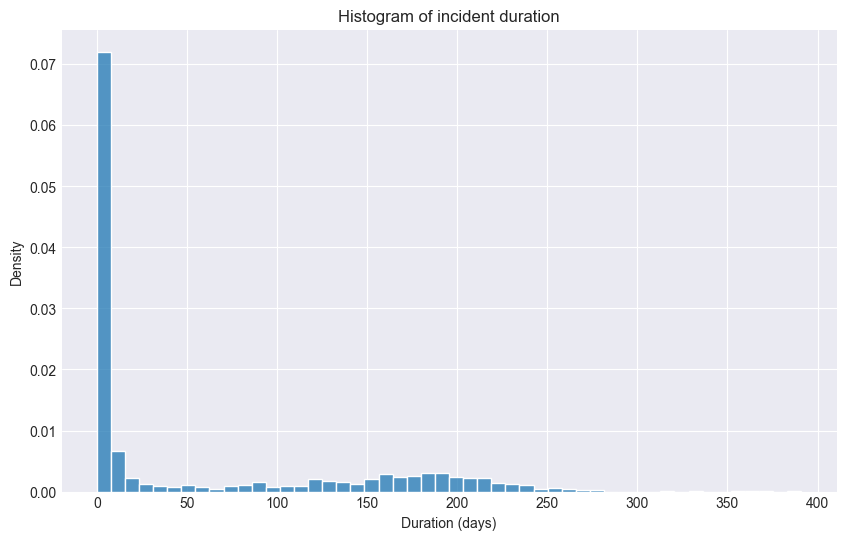

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
df['duration'] = df['incident_date_extinguished'] - df['incident_date_created']
df.loc[df['duration'] < pd.Timedelta(0), 'duration'] = pd.NaT
df['duration_days'] = df['duration'].dt.days

plt.figure(figsize=(10,6))
sns.histplot(df['duration_days'], bins = 50, kde = False, stat = 'density')
plt.title('Histogram of incident duration')
plt.xlabel('Duration (days)')
plt.ylabel('Density')
plt.show()


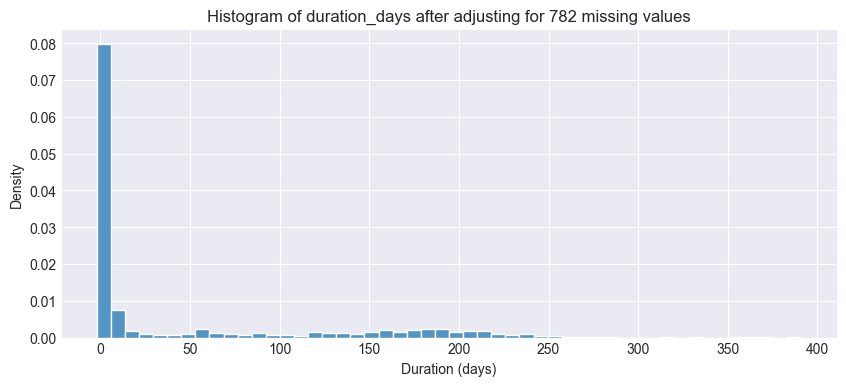

In [31]:
import numpy as np
mean_duration = df['duration_days'].mean()
duration_na_count = df['duration'].isna().sum()


df.loc[df['duration_days'].isna() & (df['incident_acres_burned'] >= 1000), 'duration_days'] = \
    np.random.normal(loc=mean_duration, scale=5, size=(df["duration_days"].isna() & (df["incident_acres_burned"] >= 1000)).sum()).round()
df.loc[df['duration_days'].isna() & (df['incident_acres_burned'] < 1000), 'duration_days'] = \
    np.random.normal(loc=1, scale=1, size=(df["duration_days"].isna() & (df["incident_acres_burned"] < 1000)).sum()).round()

plt.figure(figsize=(10,4))
sns.histplot(df['duration_days'], bins = 50, kde = False, stat = 'density')
plt.title(f'Histogram of duration_days after adjusting for {duration_na_count} missing values')
plt.xlabel('Duration (days)')
plt.ylabel('Density')
plt.show()

In [32]:
df.isnull().sum()

id                                  0
incident_name                       0
incident_date_created               0
incident_administrative_unit       58
incident_county                     0
incident_location                   0
incident_acres_burned               0
incident_containment                0
incident_cooperating_agencies    1517
incident_longitude                  0
incident_latitude                   0
incident_id                         0
incident_url                        0
incident_date_extinguished        706
is_active                           0
calfire_incident                    0
data_loaded_date                    0
duration                          782
duration_days                       0
dtype: int64

Now that we have completed our data manipulation when it comes to NaN values, we can look at any outliers our data may possess.

### Handling Outliers
With a database such as this that covers such a broad range of attributes (think about how many varying the longitude value could be across the entire state of California), we need to be creative in order to assure that all values are acting accordingly.

The first notion that comes to mind, as just stated, is incident_longitude and incident_latitude. These two values, while quite varying, need to fit into the state of California in order to qualify for our assessment. When putting the data into a geospatial map, it is apparent that some of these latitude, longitude combinations are out of range or null. We can fix this by finding the average of 'incident_longitude' and 'incident_latitude' across the dataset when 'incident_county' is the same as the outlier's. With how many data entries there are in this database, it's unlikely the outliers will have a significant effect on the data when their manipulated like this.

In [33]:
if 'incident_latitude_clean' not in df.columns:
    df['incident_latitude_clean'] = df['incident_latitude']
if 'incident_longitude_clean' not in df.columns:
    df['incident_longitude_clean'] = df['incident_longitude']

def is_outlier(lat, lon):
    if pd.isna(lat) or pd.isna(lon):
        return True
    return not (32.5 <= lat <= 42 and -124.5 <= lon <= -114)

df['incident_latitude_clean'] = df.apply(
    lambda row: np.nan if is_outlier(row['incident_latitude'], row['incident_longitude'])
    else row['incident_latitude'],
    axis=1
)

df['incident_longitude_clean'] = df.apply(
    lambda row: np.nan if is_outlier(row['incident_latitude'], row['incident_longitude'])
    else row['incident_longitude'],
    axis=1
)

county_means = df.groupby('incident_county')[['incident_longitude_clean', 'incident_latitude_clean']].mean()
df = df.join(county_means, on='incident_county', rsuffix='_county_avg')

df['incident_latitude_clean'] = df['incident_latitude_clean'].fillna(df['incident_latitude_clean_county_avg'])
df['incident_longitude_clean'] = df['incident_longitude_clean'].fillna(df['incident_longitude_clean_county_avg'])
df = df.drop(['incident_latitude_clean_county_avg', 'incident_longitude_clean_county_avg'], axis=1)

print(df[['incident_latitude_clean', 'incident_longitude_clean']].describe())

       incident_latitude_clean  incident_longitude_clean
count              2958.000000               2958.000000
mean                 37.011790               -120.086735
std                   2.511616                  2.005627
min                  32.557566               -124.362017
25%                  34.700385               -121.631921
50%                  37.062258               -120.451085
75%                  38.998046               -118.541133
max                  41.999341               -114.276308


Now we can look towards other important variables, so next lets handle the 'duration' variable that we created earlier. If there are outliers, we will follow the standard data analytics practice of setting the upper limit equal the interquartile range multiplied by 1.6 which is then added to the value at 75th percentile. This step is important as performing an internet search query for "Longest lasting California Fire" results in the Mendocino Complex Fire, which lasts 161 days, which is shorter than a decent portion of our data. It is understandable and therefore somewhat accurate to allow fire duration to last longer than this value. This is in part because while a fire might still have hot spots, its containment is roughly or near 100%

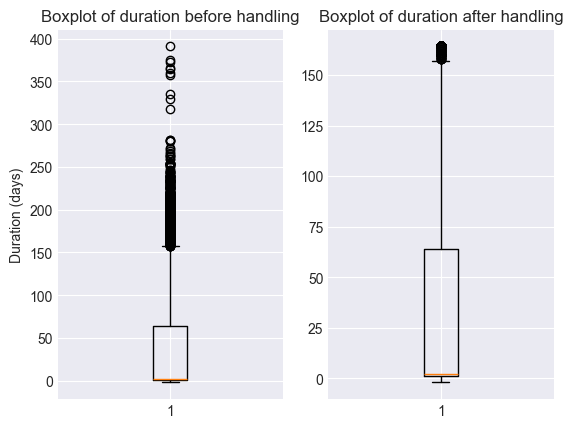

In [34]:
df_original = df.copy()
df_subset = df.copy()

percentile25 = df['duration_days'].quantile(0.25)
percentile75 = df['duration_days'].quantile(0.75)
iqr = percentile75 - percentile25
upper_limit = percentile75 + 1.6 * iqr
df_subset.loc[df_subset['duration_days'] > upper_limit, 'duration_days'] = upper_limit

fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2)
ax1.boxplot(x=df_original['duration_days'])
ax1.set_title('Boxplot of duration before handling')
ax1.set_ylabel('Duration (days)')

ax2.boxplot(x=df_subset['duration_days'])
ax2.set_title('Boxplot of duration after handling')
plt.show()

## Step 3. Continued Data Exploration & Feature Engineering

Now that we have cleaned the majority of our data for missing values and outliers, we can look towards techniques to increase the 'usability' of our data. Once such way of performing these tasks is through feature engineering. The first step we can take is pretty simple, extracting date elements out of 'incident_date_created' in order to point out recurring trends.

In [35]:
df_subset['incident_year'] = df_subset['incident_date_created'].dt.year
df_subset['incident_month'] = df_subset['incident_date_created'].dt.month
df_subset['is_fire_season'] = df_subset['incident_month'].apply(lambda x: 1 if x in [6,7,8,9,10] else 0)
df_subset['incident_season'] = df_subset['incident_month'].apply(
    lambda x: 'Winter' if x in [12,1,2] else 'Spring' if x in [3,4,5] else 'Summer' if x in [6,7,8] else 'Fall')

In [36]:
df_subset['is_fire_season'].value_counts()
2432/(2432 + 523)

0.8230118443316413

With this, we can check the distribution of fires throughout the year in accordance with the month.

INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


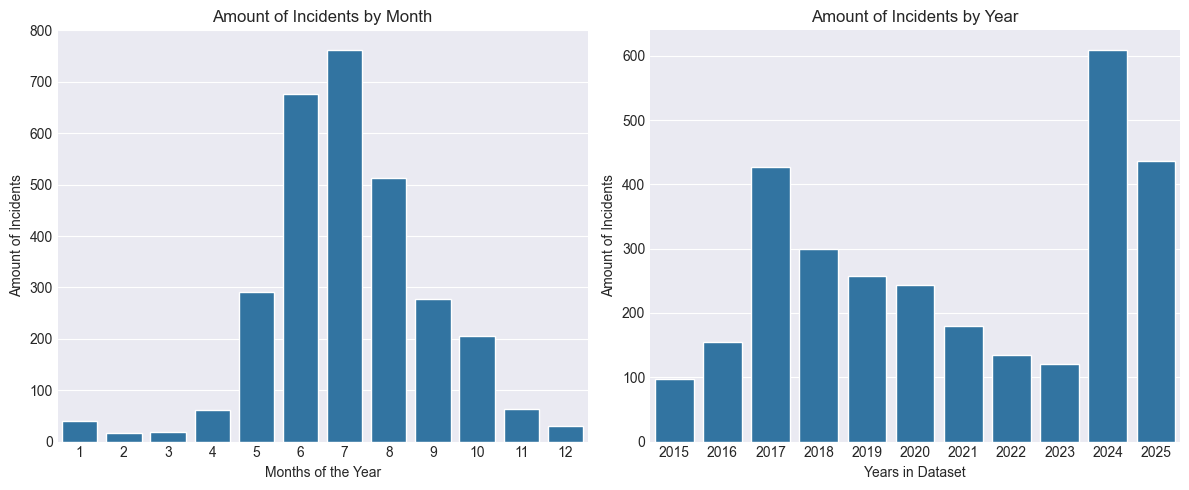

Percentage of Fires in Wildfire Season: 82.32%


In [37]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.countplot(df_subset, x = 'incident_year', ax = axes[1])
axes[1].set_title("Amount of Incidents by Year")
axes[1].set_xlabel('Years in Dataset')
axes[1].set_ylabel('Amount of Incidents')
sns.countplot(df_subset, x = 'incident_month', ax = axes[0])
axes[0].set_title("Amount of Incidents by Month")
axes[0].set_xlabel('Months of the Year')
axes[0].set_ylabel('Amount of Incidents')
plt.tight_layout()
plt.show()
season_percentage = (df_subset['is_fire_season'] == 1).sum() / df_subset['is_fire_season'].count() * 100
print(f"Percentage of Fires in Wildfire Season: {season_percentage:.2f}%")

From the graphs featured above, we can see a trend of regularity within the wildfire season. From the left count plot, "Amount of Incidents by Month", shows a distinct pattern of just how many incidents occur during the wildfire season in comparison to the rest of the year. In the northern hemisphere, it is generally considered that the months of May through October are commonly considered the main months of activity. This is proven by the distribution of incidents across the year. At the time of analysis, approximately 82.32% of fires occur during May - October, with July having the highest number of incidents total. As for the count plot on the left, we can see the composition of years that make up our dataset. It is immediately noticeable that there is a skew favoring towards the right side of the data where the years are most recent. This is an interesting pattern that we should look into further. For this reason, the two count graphs below are more specialized, as they demonstrate the same information except strictly limited to fires over 1,000 and 10,000 acres respectively. As apparent, the data tells us a drastically different story: a multi-year pattern appears to exist across the time range. Because our dataset is limited in the amount of information available across history, we may not be able to extract all critical trends that exist within wildfire seasonality, but we will look further into this trend during the Time Series Forecasting section of our analysis.

INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


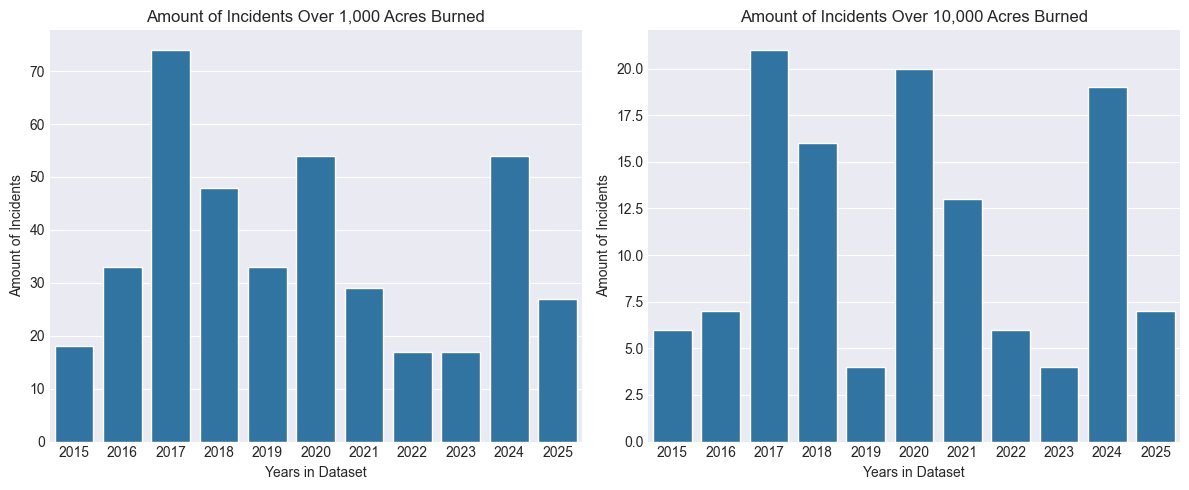

In [38]:
df_1e4_fires = df_subset[df_subset['incident_acres_burned'] > 10000]
df_1e3_fires = df_subset[df_subset['incident_acres_burned'] > 1000]
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.countplot(df_1e3_fires, x = 'incident_year', ax = axes[0])
axes[0].set_title("Amount of Incidents Over 1,000 Acres Burned")
axes[0].set_xlabel('Years in Dataset')
axes[0].set_ylabel('Amount of Incidents')
sns.countplot(df_1e4_fires, x = 'incident_year', ax = axes[1])
axes[1].set_title("Amount of Incidents Over 10,000 Acres Burned")
axes[1].set_xlabel('Years in Dataset')
axes[1].set_ylabel('Amount of Incidents')
plt.tight_layout()
plt.show()

In [39]:
county_stats = df.groupby('incident_county').agg(
    mean_county_firesize = ('incident_acres_burned', 'mean'),
    total_county_firesize = ('incident_acres_burned', 'sum'),
    num_incidents = ('incident_name', 'count')
).reset_index()
top_counties_acres = county_stats.sort_values(by = 'total_county_firesize', ascending = False)
top_counties_mean = county_stats.sort_values(by = 'mean_county_firesize', ascending = False)
top_counties_amount = county_stats.sort_values(by = 'num_incidents', ascending = False)

The code block above sorts counties into their respective categories of total acres burned, mean acres burned per incident, and total number of incidents. These metrics can provide an insight into how "at-risk" a county is for wildfires. When crossed referenced with a county's total acre size and ratio of urbanization:wilderness (such as buildings versus forests) can tell us the most active counties.

<Figure size 1200x600 with 0 Axes>

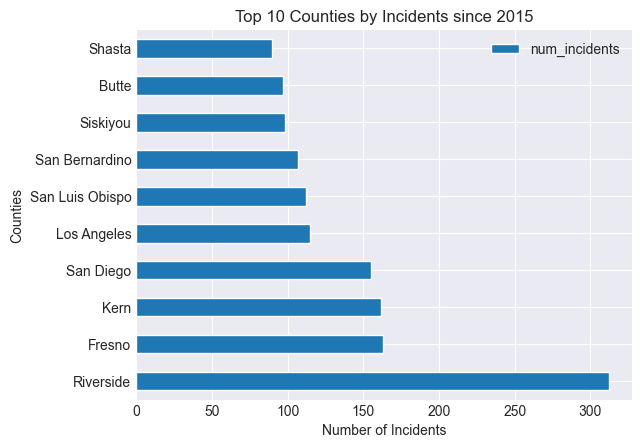

In [40]:
plt.figure(figsize=(12, 6))
top_counties_amount.head(10).plot(kind='barh', x='incident_county', y='num_incidents')
plt.title('Top 10 Counties by Incidents since 2015')
plt.xlabel('Number of Incidents')
plt.ylabel('Counties')
plt.show()

The output above demonstrates the top five counties with the highest number of incidents. At the time of analysis, Riverside county has the greatest number of incidents in the dataset at a value of 312, followed by Fresno with 163 incidents, then by Kern County, San Diego, and Los Angeles. The list of largest counties by total area in descending order is San Bernardino , Inyo, Kern, Riverside, and Siskiyou Counties. This means that a county's size does not necessarily dictate it's number of incidents. This is likely because more urban areas have a greater number of smaller incidents, while areas with more wilderness acres have fewer, but larger fires.

<Figure size 1200x600 with 0 Axes>

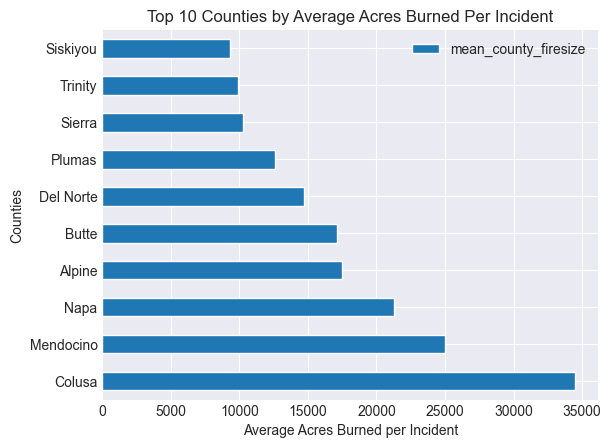

In [41]:
plt.figure(figsize=(12, 6))
top_counties_mean.head(10).plot(kind='barh', x='incident_county', y='mean_county_firesize')
plt.title('Top 10 Counties by Average Acres Burned Per Incident')
plt.xlabel('Average Acres Burned per Incident')
plt.ylabel('Counties')
plt.show()

As just directly mentioned, areas with more wilderness acres have fewer, but larger fires. The output block above shows this directly as it displays the average acres burned per incident within the top counties for this statistic. None of the counties on either of the last lists (top counties by amount and top counties by size) sit anywhere in the top 5. This shows that while these counties may not have as many incidents as the other counties, but incidents are drastically larger.

<Figure size 1200x600 with 0 Axes>

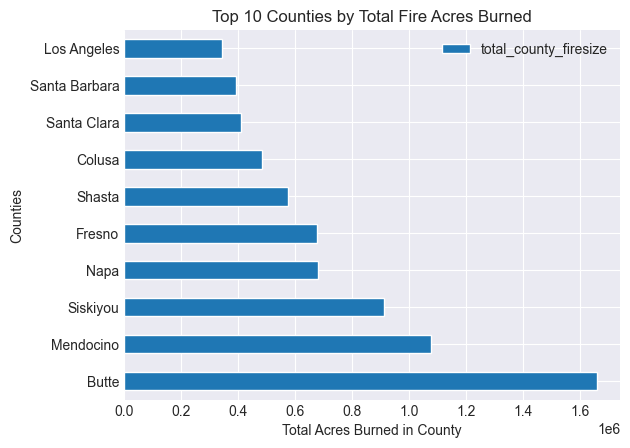

In [42]:
plt.figure(figsize=(12, 6))
top_counties_acres.head(10).plot(kind='barh', x='incident_county', y='total_county_firesize')
plt.title('Top 10 Counties by Total Fire Acres Burned')
plt.xlabel('Total Acres Burned in County')
plt.ylabel('Counties')
#.ticklabel_format(style='plain', axis='x')
plt.show()

This last output shows us the total acres burned across the time range of the data set. At the time of analysis, Butte County is sitting on top with 1,658,041 acres burned in wildfires since the beginning of 2015 and Mendocino County is second with 1,076,400 acres.

C:\Users\orion\AppData\Local\Temp\ipykernel_13796\1552020383.py:27: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 0].boxplot([df_subset[df_subset['incident_season'] == s]['incident_acres_burned']
DEBUG - vmin 10.407310574363805 vmax 1786019.9200537703
DEBUG - ticklocs array([1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06, 1.e+07,
       1.e+08])
DEBUG - vmin 10.407310574363805 vmax 1786019.9200537703
DEBUG - ticklocs array([2.e+00, 3.e+00, 4.e+00, 5.e+00, 6.e+00, 7.e+00, 8.e+00, 9.e+00,
       2.e+01, 3.e+01, 4.e+01, 5.e+01, 6.e+01, 7.e+01, 8.e+01, 9.e+01,
       2.e+02, 3.e+02, 4.e+02, 5.e+02, 6.e+02, 7.e+02, 8.e+02, 9.e+02,
       2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03, 9.e+03,
       2.e+04, 3.e+04, 4.e+04, 5.e+04, 6.e+04, 7.e+04, 8.e+04, 9.e+04,
       2.e+05, 3.e+05, 4.e+05, 5.e+05, 6.e+05, 7.e+05, 8.e+05, 9.e+05,
       2.e+0

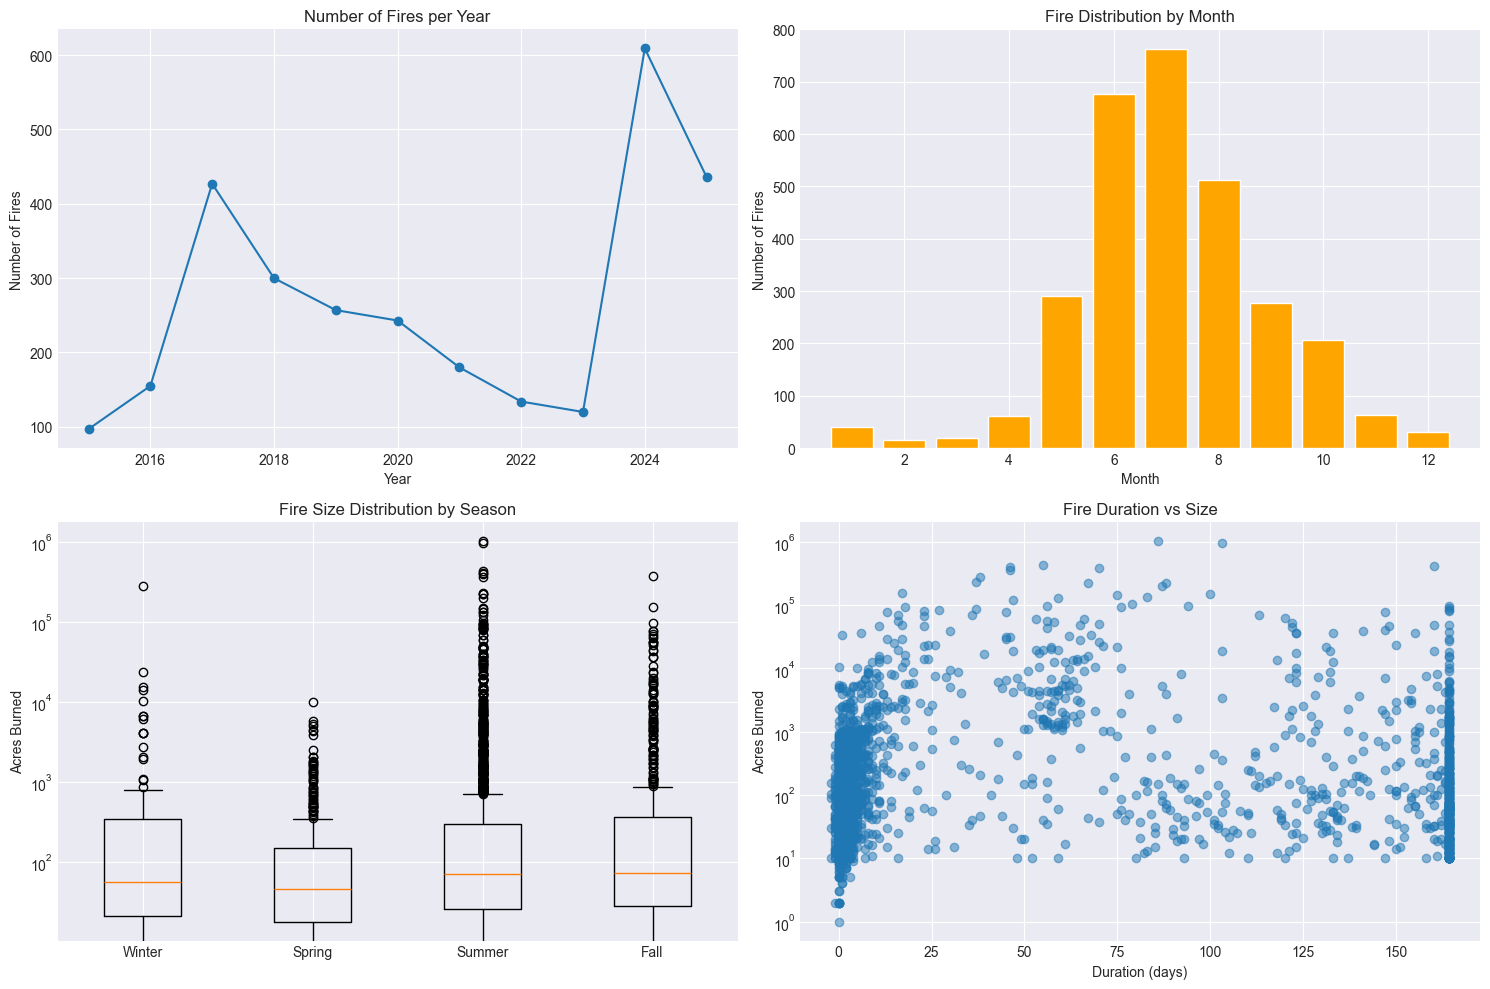

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Yearly trend
yearly_stats = df_subset.groupby('incident_year').agg({
    'incident_id': 'count',
    'incident_acres_burned': 'sum'
}).reset_index()

axes[0, 0].plot(yearly_stats['incident_year'], yearly_stats['incident_id'], marker='o')
axes[0, 0].set_title('Number of Fires per Year')
axes[0, 0].set_xlabel('Year')
axes[0, 0].set_ylabel('Number of Fires')

# Monthly distribution
monthly_fires = df_subset['incident_month'].value_counts().sort_index()
axes[0, 1].bar(monthly_fires.index, monthly_fires.values, color='orange')
axes[0, 1].set_title('Fire Distribution by Month')
axes[0, 1].set_xlabel('Month')
axes[0, 1].set_ylabel('Number of Fires')

# Fire size by season
axes[1, 0].boxplot([df_subset[df_subset['incident_season'] == s]['incident_acres_burned']
                     for s in ['Winter', 'Spring', 'Summer', 'Fall']],
                    labels=['Winter', 'Spring', 'Summer', 'Fall'])
axes[1, 0].set_title('Fire Size Distribution by Season')
axes[1, 0].set_ylabel('Acres Burned')
axes[1, 0].set_yscale('log')

# Duration vs Acres correlation
axes[1, 1].scatter(df_subset['duration_days'], df_subset['incident_acres_burned'], alpha=0.5)
axes[1, 1].set_xlabel('Duration (days)')
axes[1, 1].set_ylabel('Acres Burned')
axes[1, 1].set_title('Fire Duration vs Size')
axes[1, 1].set_yscale('log')

plt.tight_layout()
plt.show()

## Importing Precipitation Data

Knowing precipitation data for our machine learning predictive models allows us to combine the metrics of wildfires with rainfall. This can give us a deep insight into how "wet years" coincide with higher risks of wildfires.

The first step is to run the Python script to download precipitation data from the California's governmental database. The database will automatically be cleaned and provide the latest insights.

In [44]:
import download_precip

if os.path.exists('county_precipitation_data.csv'):
    precip_df = pd.read_csv('county_precipitation_data.csv')
else:
    precip_df = download_precip.precipDownloaderAPI()

# Machine Learning

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

numerical_features = [
    'incident_latitude_clean', 'incident_longitude_clean',
    'incident_month', 'incident_year', 'is_fire_season', ''
]
df_subset

,incident_name,incident_date_created,incident_administrative_unit,incident_county,incident_location,incident_acres_burned,incident_containment,incident_cooperating_agencies,incident_longitude,incident_latitude,...,is_active,calfire_incident,duration,duration_days,incident_latitude_clean,incident_longitude_clean,incident_year,incident_month,is_fire_season,incident_season
0,Bridge Fire,2017-10-31 11:22:00+00:00,Shasta-Trinity National Forest,Shasta,"I-5 and Turntable Bay, 7 miles NE of Shasta Lake",37.0,100.0,Shasta-Trinity National Forest,-122.309000,40.774000,...,N,False,70 days 02:24:00,70.0,40.774000,-122.309000,2017,10,1,Fall
212,Stephens Fire,2015-02-24 12:15:00+00:00,Shasta-Trinity National Forest,Siskiyou,"Approx. 18 miles northeast of McCloud, just so...",200.0,100.0,Shasta-Trinity National Forest,-121.851000,41.485000,...,N,False,5 days 20:45:00,5.0,41.485000,-121.851000,2015,2,0,Winter
220,Otay Fire,2015-06-26 16:06:00+00:00,CAL FIRE San Diego Unit / Chula Vista Fire Dep...,San Diego,off Otay Lakes Road and Woods Drive in Chula V...,80.0,100.0,CAL FIRE San Diego Unit / Chula Vista Fire Dep...,-116.945439,32.644916,...,N,True,0 days 06:09:00,0.0,32.644916,-116.945439,2015,6,1,Summer
221,Ward Fire,2015-04-13 05:30:00+00:00,**This was NOT a CAL FIRE Incident. Click this...,Plumas,East of Taylorsville,137.0,100.0,**This was NOT a CAL FIRE Incident. Click this...,-120.701667,40.050833,...,N,True,5 days 18:20:00,5.0,40.050833,-120.701667,2015,4,0,Spring
222,Highway Fire,2015-04-18 18:12:00+00:00,CAL FIRE/Riverside County Fire,Riverside,at Hwy 71/Hwy 91 near the Prado Basin,1049.0,100.0,"CAL FIRE/Riverside County Fire, City of Corona...",-117.642759,33.884313,...,N,True,5 days 13:18:00,5.0,33.884313,-117.642759,2015,4,0,Spring
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3244,3-22 Muck Fire,2025-08-25 19:56:05+00:00,CAL FIRE Lassen-Modoc Unit,Lassen,"South of Third Butte and Muck Valley Road, Nor...",40.0,50.0,NaN,-121.227729,40.977490,...,Y,True,NaT,0.0,40.977490,-121.227729,2025,8,1,Summer
3245,Paskenta Fire,2025-08-25 20:06:27+00:00,CAL FIRE Tehama-Glenn Unit,Tehama,"Rancho Tehama Road, Corning",65.0,100.0,NaN,-122.298489,40.000740,...,N,True,NaT,1.0,40.000740,-122.298489,2025,8,1,Summer
3246,Peak Fire,2025-08-25 15:30:36+00:00,Shasta-Trinity National Forest,Trinity,West of Trinity Lake,290.0,0.0,NaN,-122.853027,40.910107,...,Y,False,NaT,2.0,40.910107,-122.853027,2025,8,1,Summer
3247,6-3 Fire,2025-08-26 11:33:20+00:00,CAL FIRE Butte Unit,Butte,"Wilbur Road and Nelson Ave, West Oroville",11.0,100.0,NaN,-121.650849,39.523797,...,N,True,0 days 01:26:40,0.0,39.523797,-121.650849,2025,8,1,Summer
